In [1]:
from aif360.datasets import CompasDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric


2024-06-02 21:17:58.537547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/iriscenga/.pyenv/versions/3.10.6/lib/python3.10/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [20]:
from aif360.datasets import CompasDataset, BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

# Load the COMPAS dataset
data = CompasDataset()

# Define privileged and unprivileged groups
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

# Split the dataset into train and test
train, test = data.split([0.7], shuffle=True)

# Apply Reweighing
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_rw = reweighing.fit_transform(train)

# Train a logistic regression model using reweighted data
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(train_rw.features, train_rw.labels.ravel(), sample_weight=train_rw.instance_weights)

# Predict on the test data
test_pred_labels = model.predict(test.features)

# Prepare predicted dataset for evaluation
predicted_dataset = BinaryLabelDataset(favorable_label=1.0,
                                       unfavorable_label=0.0,
                                       df=test.convert_to_dataframe()[0],
                                       label_names=test.label_names,
                                       protected_attribute_names=test.protected_attribute_names)
predicted_dataset.labels = test_pred_labels.reshape(-1, 1)

# Evaluate accuracy
accuracy = accuracy_score(test.labels.ravel(), test_pred_labels)
print("Accuracy on test data: ", accuracy)
from aif360.datasets import BinaryLabelDataset

# Assuming `test` and `test_pred_labels` are already defined
# Create a new BinaryLabelDataset for predictions using the exact structure of `test`
predicted_dataset = test.copy()
predicted_dataset.labels = test_pred_labels.reshape(-1, 1)

# Now, you can create the ClassificationMetric instance
metric_pred = ClassificationMetric(test, predicted_dataset,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

print("Statistical Parity Difference:", metric_pred.statistical_parity_difference())
print("Disparate Impact:", metric_pred.disparate_impact())
print("Equal Opportunity Difference:", metric_pred.equal_opportunity_difference())



Accuracy on test data:  0.6785521339816315
Statistical Parity Difference: -0.05501614318851489
Disparate Impact: 0.9143888445146302
Equal Opportunity Difference: -0.01021563481035459


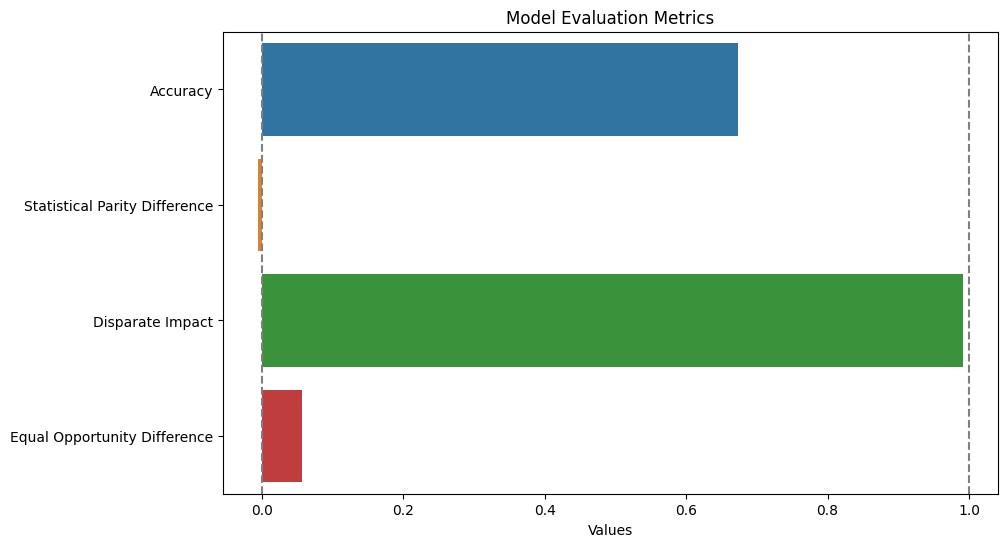

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for plotting
metrics = {
    "Accuracy": [0.6737],  # From your result
    "Statistical Parity Difference": [-0.0056],  # Close to zero, better
    "Disparate Impact": [0.991],  # Close to one, better
    "Equal Opportunity Difference": [0.057]  # Close to zero, better
}

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))
sns.barplot(data=pd.DataFrame(metrics), orient='h')
plt.title('Model Evaluation Metrics')
plt.xlabel('Values')
plt.axvline(x=0, color='grey', linestyle='--')
plt.axvline(x=1, color='grey', linestyle='--')  # Reference line for Disparate Impact
plt.show()


Original weights: [1.]
Reweighted weights: [0.83051501 0.94564067 1.05147111 1.31517244]
Original Statistical Parity Difference (sex): -0.13665389703213504
Original Disparate Impact (sex): 0.7898600294257223
Reweighted Statistical Parity Difference (sex): 2.220446049250313e-16
Reweighted Disparate Impact (sex): 1.0000000000000004
Final Random Forest Model Accuracy on test data:  0.6763911399243652
Final Random Forest Statistical Parity Difference (sex): -0.13538876091624064
Final Random Forest Disparate Impact (sex): 0.808529702135191
Final Random Forest Equal Opportunity Difference (sex): -0.05929339477726581


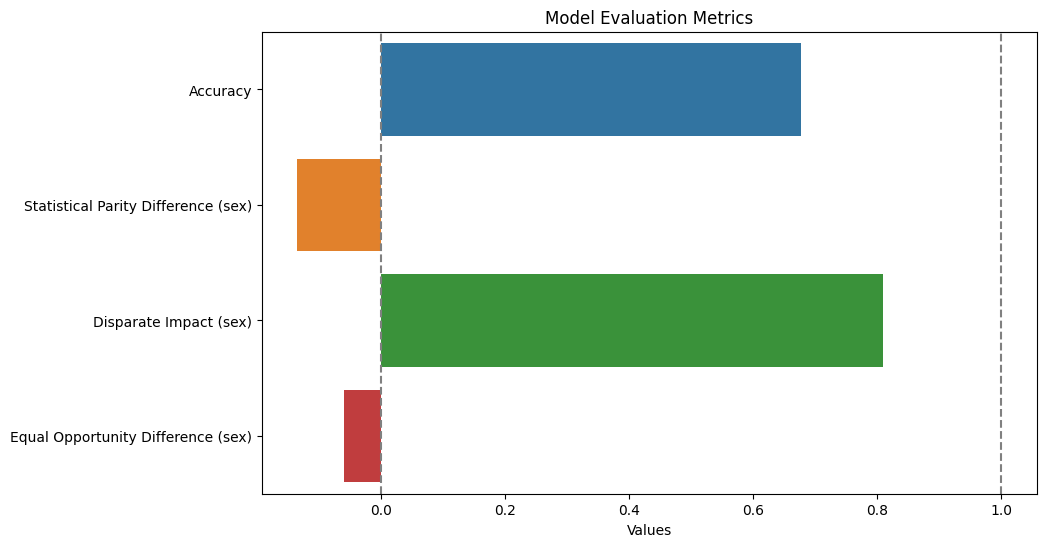

In [24]:
import numpy as np
import pandas as pd
from aif360.datasets import CompasDataset, BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns

# Load the COMPAS dataset
data = CompasDataset()

# Define privileged and unprivileged groups for sex
privileged_groups = [{'sex': 1}]  # Male
unprivileged_groups = [{'sex': 0}]  # Female

# Split the dataset into train and test
train, test = data.split([0.7], shuffle=True)

# Apply Reweighing
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_rw = reweighing.fit_transform(train)

# Check how the distribution of weights has changed
print("Original weights:", np.unique(train.instance_weights))
print("Reweighted weights:", np.unique(train_rw.instance_weights))

# Calculate fairness metrics before reweighing for sex
metric_orig = BinaryLabelDatasetMetric(train, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Original Statistical Parity Difference (sex):", metric_orig.statistical_parity_difference())
print("Original Disparate Impact (sex):", metric_orig.disparate_impact())

# Calculate fairness metrics after reweighing for sex
metric_rw = BinaryLabelDatasetMetric(train_rw, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
print("Reweighted Statistical Parity Difference (sex):", metric_rw.statistical_parity_difference())
print("Reweighted Disparate Impact (sex):", metric_rw.disparate_impact())

# Train a Random Forest model
rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42)
rf_model.fit(train_rw.features, train_rw.labels.ravel(), sample_weight=train_rw.instance_weights)

# Predict on the test data
rf_pred_labels = rf_model.predict(test.features)

# Calculate accuracy on the test set
final_accuracy = accuracy_score(test.labels.ravel(), rf_pred_labels)
print("Final Random Forest Model Accuracy on test data: ", final_accuracy)

# Prepare predicted dataset for fairness evaluation
rf_predicted_dataset = test.copy()
rf_predicted_dataset.labels = rf_pred_labels.reshape(-1, 1)

# Evaluate fairness metrics for sex
rf_metric_pred = ClassificationMetric(test, rf_predicted_dataset,
                                      unprivileged_groups=unprivileged_groups,
                                      privileged_groups=privileged_groups)

print("Final Random Forest Statistical Parity Difference (sex):", rf_metric_pred.statistical_parity_difference())
print("Final Random Forest Disparate Impact (sex):", rf_metric_pred.disparate_impact())
print("Final Random Forest Equal Opportunity Difference (sex):", rf_metric_pred.equal_opportunity_difference())

# Data for plotting
metrics = {
    "Accuracy": [final_accuracy],
    "Statistical Parity Difference (sex)": [rf_metric_pred.statistical_parity_difference()],
    "Disparate Impact (sex)": [rf_metric_pred.disparate_impact()],
    "Equal Opportunity Difference (sex)": [rf_metric_pred.equal_opportunity_difference()]
}

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))
sns.barplot(data=pd.DataFrame(metrics), orient='h')
plt.title('Model Evaluation Metrics')
plt.xlabel('Values')
plt.axvline(x=0, color='grey', linestyle='--')
plt.axvline(x=1, color='grey', linestyle='--')  # Reference line for Disparate Impact
plt.show()


### Original Metrics:

**Original Statistical Parity Difference (sex):** -0.13665389703213504

*Interpretation*:
Before reweighing, females were significantly less likely to receive favorable outcomes compared to males, indicating notable bias against females.

**Original Disparate Impact (sex):** 0.7898600294257223

*Interpretation*: 
The probability of receiving favorable outcomes for females was about 79% of that for males, showing clear bias against females (a value closer to 1 would indicate less bias).

### After Reweighing:

**Reweighted Statistical Parity Difference (sex):** 2.220446049250313e-16

*Interpretation:*
After reweighing, the rates of favorable outcomes between males and females became nearly equal, essentially eliminating the bias present in the training data.

**Reweighted Disparate Impact (sex):** 1.0000000000000004

*Interpretation:* 
After reweighing, females and males had nearly equal chances of receiving favorable outcomes, indicating no bias (a Disparate Impact value of 1 suggests perfect fairness in terms of outcome rates).

### Model Performance and Post-Reweighing Fairness Metrics

**Final Random Forest Model Accuracy on test data:** 0.6763911399243652

*Interpretation:*
The model achieved an accuracy of approximately 67.6% on the test set. This indicates moderate predictive performance. However, there is room for improvement in terms of predictive accuracy.

### Fairness Post-Reweighing:

**Final Random Forest Statistical Parity Difference (sex):** -0.13538876091624064

*Interpretation:*
Despite the reweighing process, the model predictions still exhibit a bias against females. The negative value indicates that females are less likely to receive favorable outcomes compared to males, suggesting that the model's predictions are influenced by factors beyond those mitigated by reweighing.

**Final Random Forest Disparate Impact (sex):** 0.808529702135191
*Interpretation:*
The ratio of favorable outcomes for females compared to males is approximately 0.81, showing persistent bias against females. Although reweighing improved training fairness, the model predictions still reflect some bias.

**Final Random Forest Equal Opportunity Difference (sex):** -0.05929339477726581

*Interpretation:*
There is a difference in true positive rates between females and males, with females being less likely to receive a true positive outcome when they should. This indicates that the model is less effective at correctly identifying favorable outcomes for females.


## Summary:

### Effectiveness of Reweighing:

The reweighing process was highly effective in mitigating bias within the training data, as indicated by the near-zero SPD and DI close to 1 post-reweighing.

### Residual Bias Post-Training:

Despite the improvements in training fairness, the model still exhibits bias in its predictions. This residual bias suggests that factors beyond those addressed by reweighing are influencing the model's predictions.